## Real estate appraisal (portugese)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from IPython.display import display

Carregamos os conjuntos de dados de treinamento/teste

In [2]:
train=pd.read_csv('conjunto_de_treinamento.csv')
test=pd.read_csv('conjunto_de_teste.csv')

Vamos visualizar um pouco os dados.

In [3]:
train.head().T

,0,1,2,3,4
Id,2000,2001,2002,2003,2004
tipo,Casa,Apartamento,Apartamento,Apartamento,Apartamento
bairro,Imbiribeira,Casa Amarela,Encruzilhada,Boa Viagem,Rosarinho
tipo_vendedor,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria
quartos,3,4,3,4,2
suites,3,4,1,3,1
vagas,5,2,0,2,1
area_util,223,157,53,149,54
area_extra,167,0,0,0,0
diferenciais,piscina e copa,piscina e churrasqueira,nenhum,piscina e churrasqueira,piscina e churrasqueira


In [4]:
diferencais_split = train['diferenciais'].str.get_dummies(sep=' e ')
diferencais_split.head()

,campo de futebol,children care,churrasqueira,copa,esquina,estacionamento visitantes,frente para o mar,hidromassagem,nenhum,piscina,playground,quadra de squash,quadra poliesportiva,sala de ginastica,salao de festas,salao de jogos,sauna,vestiario
0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Vemos que alguns dos valores em <span style="color:#4169E1">'diferenciais'</span> não estão listados no restante do conjunto de dados, por exemplo, copa. Proponho excluir as colunas existentes para adicionar todos os diferenciais possíveis. Vamos adicioná-los posteriormente ao fazer a codificação.

In [5]:
train=train.drop(columns=['churrasqueira',
       'estacionamento', 'piscina', 'playground', 'quadra', 's_festas',
       's_jogos', 's_ginastica', 'sauna', 'vista_mar'])

test=test.drop(columns=['churrasqueira',
       'estacionamento', 'piscina', 'playground', 'quadra', 's_festas',
       's_jogos', 's_ginastica', 'sauna', 'vista_mar'])

In [6]:
train.head()

,Id,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,preco
0,2000,Casa,Imbiribeira,Imobiliaria,3,3,5,223,167,piscina e copa,1000000.0
1,2001,Apartamento,Casa Amarela,Imobiliaria,4,4,2,157,0,piscina e churrasqueira,680000.0
2,2002,Apartamento,Encruzilhada,Imobiliaria,3,1,0,53,0,nenhum,450000.0
3,2003,Apartamento,Boa Viagem,Imobiliaria,4,3,2,149,0,piscina e churrasqueira,1080000.0
4,2004,Apartamento,Rosarinho,Imobiliaria,2,1,1,54,0,piscina e churrasqueira,350000.0


##### Para plotar gráficos e ajudar a entender os dados, primeiro precisamos remover os outliers
Aqui, vou usar o método IQR

Como sabemos que a 'area_util' tem uma grande influência no preço, achei interessante criar um novo dado que é o preço por metro quadrado. Isso nos ajudará a detectar e remover os outliers com mais precisão do que apenas com o preço.

In [7]:
train['preco_por_mq'] = train['preco'] / train['area_util']
train[['preco_por_mq']].describe()

,preco_por_mq
count,4.683000e+03
mean,8.615977e+03
std,1.193771e+05
min,1.315789e+01
25%,4.535960e+03
50%,5.806452e+03
75%,6.812391e+03
max,6.428571e+06


In [8]:
Q1 = train['preco_por_mq'].quantile(0.25)
Q3 = train['preco_por_mq'].quantile(0.75)
IQR = Q3 - Q1

# Definimos os limites dos outliers

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5* IQR

# Identificamos os outliers

upper_outliers = train[(train['preco_por_mq'] > upper_bound)]
lower_outliers = train[(train['preco_por_mq'] < lower_bound)]

# Calculamos o número e o percentual de outliers superiores e inferiores
total_points = train.shape[0]

num_lower_outliers = lower_outliers.shape[0]
num_upper_outliers = upper_outliers.shape[0]

percentage_upper_outliers = (num_upper_outliers / total_points) * 100
percentage_lower_outliers = (num_lower_outliers / total_points) * 100

print(f"Nombre d'outliers: {num_upper_outliers}")
print(f"Nombre total de points: {total_points}")
print(f"Pourcentages d'upper outliers: {percentage_upper_outliers:.2f}%")
print(f"Pourcentages de lower outliers: {percentage_lower_outliers:.2f}%")
print(f"Pourcentages de lower outliers: {percentage_lower_outliers+percentage_upper_outliers:.2f}%")

print(upper_bound,lower_bound)

Nombre d'outliers: 150
Nombre total de points: 4683
Pourcentages d'upper outliers: 3.20%
Pourcentages de lower outliers: 0.49%
Pourcentages de lower outliers: 3.69%
10227.035701631254 1121.3151853950635


Com esse método, removemos 3,7% do conjunto de dados, o que parece razoável.

In [9]:
train[['preco_por_mq']].describe()

,preco_por_mq
count,4.683000e+03
mean,8.615977e+03
std,1.193771e+05
min,1.315789e+01
25%,4.535960e+03
50%,5.806452e+03
75%,6.812391e+03
max,6.428571e+06


In [10]:
train = train[(train['preco_por_mq'] >= lower_bound) & (train['preco_por_mq'] <= upper_bound)]

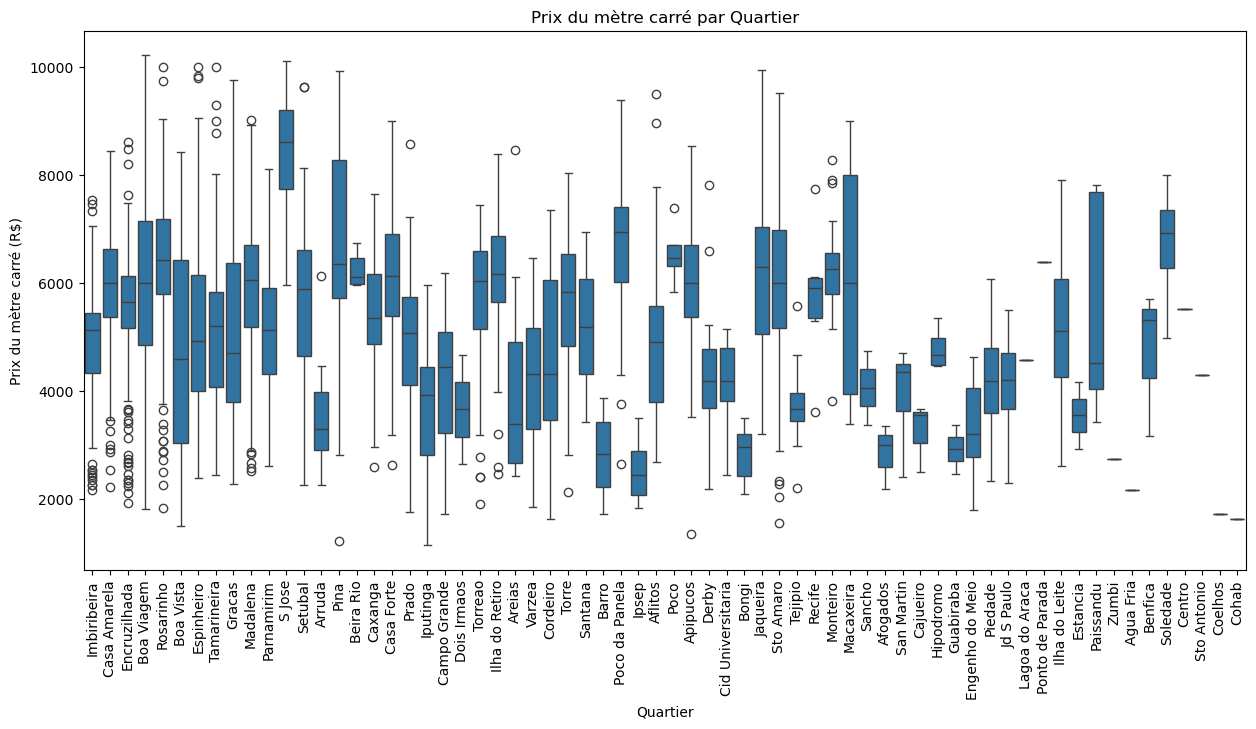

In [11]:
df=train.copy()


df = df[df['preco_por_mq'] < 1e8]
plt.figure(figsize=(15, 7))
sns.boxplot(x='bairro', y='preco_por_mq', data=df)#,fliersize=0)

plt.title('Prix du mètre carré par Quartier')
plt.xlabel('Quartier')
plt.ylabel('Prix du mètre carré (R$)')
plt.xticks(rotation=90)
plt.show()

Ainda há muitos outliers inferiores para os bairros: Imbiribeira e Encruzilhada. Vamos verificar o motivo.

In [12]:
train[train['bairro']=='Imbiribeira'].describe()
train[train['bairro']=='Encruzilhada'].describe()

,Id,quartos,suites,vagas,area_util,area_extra,preco,preco_por_mq
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,1.620000e+02,162.000000
mean,4329.537037,2.876543,1.086420,1.271605,83.240741,3.246914,4.150484e+05,5459.216864
std,1360.929141,0.675806,0.593914,0.659613,48.547192,20.939446,1.378037e+05,1255.380154
min,2002.000000,1.000000,0.000000,0.000000,43.000000,0.000000,2.170000e+05,1911.764706
25%,3299.500000,3.000000,1.000000,1.000000,61.000000,0.000000,3.400000e+05,5157.079187
50%,4220.000000,3.000000,1.000000,1.000000,65.000000,0.000000,3.800000e+05,5654.761905
75%,5367.000000,3.000000,1.000000,2.000000,79.000000,0.000000,4.347750e+05,6137.390625
max,6615.000000,6.000000,4.000000,4.000000,340.000000,185.000000,1.250000e+06,8622.941176


Bem, eu realmente não sei?? Poderíamos aplicar o método IQR nesses bairros específicos, mas como há muito poucos valores para esses dois, vamos mantê-los assim e torcer!


Sabemos que muitas casas são estimadas com este parâmetro. É particularmente interessante quando agrupado por bairro, por isso criaremos uma feature <span style="color:#FFBF00">'preco_por_mq_do_bairro'</span> que o classifica por bairro.

In [13]:
preco_por_mq_do_bairro = train.groupby('bairro')['preco_por_mq'].mean().sort_values()
train['preco_por_mq_do_bairro'] = train['bairro'].map(preco_por_mq_do_bairro)
test['preco_por_mq_do_bairro'] = test['bairro'].map(preco_por_mq_do_bairro)
train[['preco_por_mq_do_bairro']].describe()

,preco_por_mq_do_bairro
count,4510.000000
mean,5653.744438
std,692.619907
min,1625.000000
25%,5201.749371
50%,5915.547799
75%,6064.156925
max,8331.895626


In [14]:
train=train.drop(columns=['preco_por_mq'])

In [15]:

display([preco_por_mq_do_bairro])


[bairro
 Cohab             1625.000000
 Coelhos           1718.750000
 Agua Fria         2152.777778
 Ipsep             2530.607433
 Zumbi             2727.272727
                      ...     
 Poco              6537.767380
 Poco da Panela    6621.483943
 Soledade          6708.519231
 Pina              6787.615888
 S Jose            8331.895626
 Name: preco_por_mq, Length: 66, dtype: float64]

In [16]:
train[['preco_por_mq_do_bairro']].describe()


,preco_por_mq_do_bairro
count,4510.000000
mean,5653.744438
std,692.619907
min,1625.000000
25%,5201.749371
50%,5915.547799
75%,6064.156925
max,8331.895626


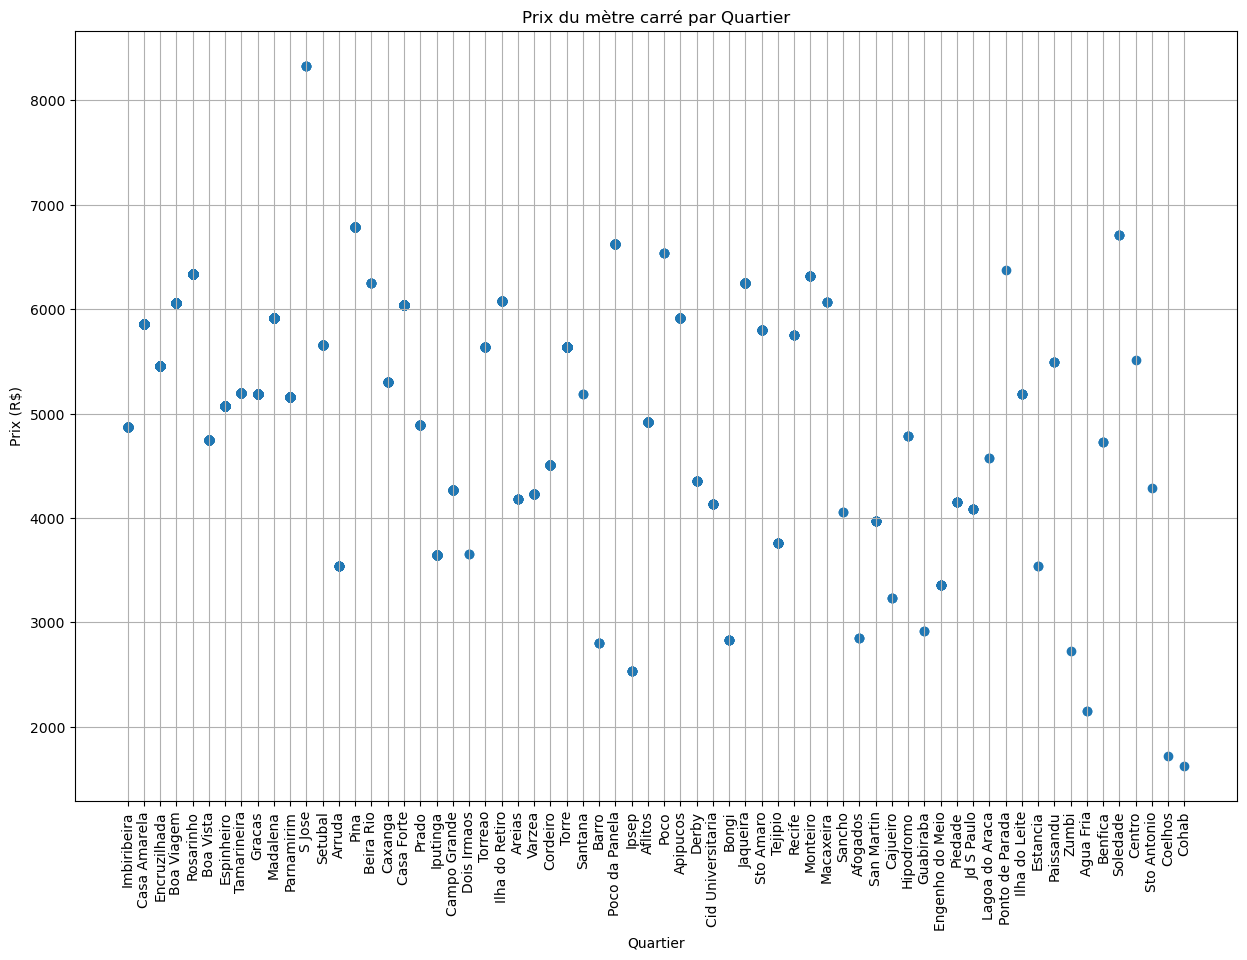

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

df = train.copy()

plt.figure(figsize=(15, 10))
plt.scatter(x=df['bairro'], y=df['preco_por_mq_do_bairro'])


plt.title('Prix du mètre carré par Quartier')
plt.xlabel('Quartier')
plt.ylabel('Prix (R$)')
plt.xticks(rotation=90)
plt.grid(True)  
plt.show()

#### Aqui codificamos nossos conjuntos de dados. Vou explicar a metodologia que segui:

1) <span style="color:#4169E1">tipo (tipo de imóvel):</span> Codificação One-Hot porque o número de categorias é manejável.

2) <span style="color:#4169E1">bairro (bairro):</span> Codificação por rótulo (Label encoding) porque o número de categorias não é manejável.

3) <span style="color:#4169E1">tipo_vendedor (tipo de vendedor):</span> Codificação One-Hot porque o número de categorias é baixo.

4) <span style="color:#4169E1">diferenciais (características adicionais):</span> Divisão das características em colunas binárias (One-Hot) pois isso parece ser uma lista de características.

In [18]:
train[train.select_dtypes(include=['object']).columns.to_list()].describe()

,tipo,bairro,tipo_vendedor,diferenciais
count,4510,4510,4510,4510
unique,4,66,2,82
top,Apartamento,Boa Viagem,Imobiliaria,piscina e churrasqueira
freq,4335,1472,4386,1303


In [19]:
from sklearn.preprocessing import LabelBinarizer,LabelEncoder

def encode(df):
    df = pd.get_dummies(df, columns=['tipo'])
    
    df['bairro'] = LabelEncoder().fit_transform(df['bairro'])

    df['tipo_vendedor'] = LabelBinarizer().fit_transform(df['tipo_vendedor'])

    diferencais_split = df['diferenciais'].str.get_dummies(sep=' e ')
    df = pd.concat([df, diferencais_split], axis=1)
    df.drop(columns=['diferenciais'], inplace=True) 
    return df 

In [20]:
train=encode(train)
test=encode(test)

Plotamos a matriz de correlação com as 15 variáveis mais correlacionadas com a variável de interesse 'preco'.


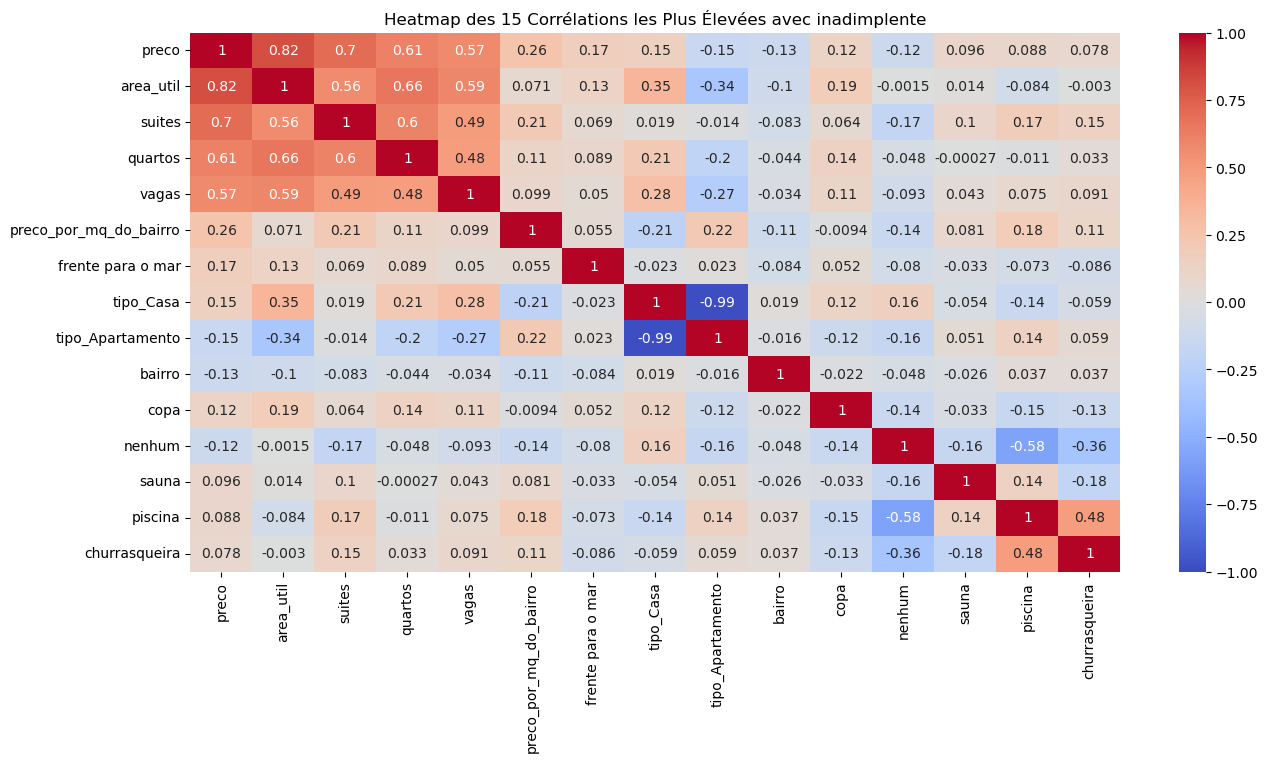

In [21]:
correlation = train.corr()

correlation_abs = correlation[['preco']].abs()

correlation_target = correlation_abs[['preco']].sort_values(by='preco', ascending=False)

top_15_columns = correlation_target.head(15).index

cm = train[top_15_columns].corr()


plt.figure(figsize=(15, 7))
sns.heatmap(cm, annot=True, cmap='coolwarm', vmin=-1, vmax=1, xticklabels=top_15_columns, yticklabels=top_15_columns)
plt.title('Heatmap des 15 Corrélations les Plus Élevées avec inadimplente')
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,HistGradientBoostingRegressor
import xgboost as xgb
import warnings

Agora selecionamos as features que julgamos mais adequadas para o nosso modelo.

In [23]:
features = ['preco','area_util','suites', 'quartos', 'vagas', 
            'preco_por_mq_do_bairro','frente para o mar',
            'tipo_Casa','bairro','copa','sauna','piscina']

In [24]:
X=train[features].drop(columns=['preco'])
y=train['preco']

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)


### Pesquisa dos Melhores Parâmetros do Modelo para RandomForest

Usamos o método RandomizedSearchCV para encontrar os melhores hiperparâmetros para nosso modelo, sempre com a validação cruzada.

In [26]:
param_grid = {
#  'learning_rate': [0.05],
   'n_estimators': [800,900,1000],
 'max_depth': [11],
# 'colsample_bytree': [0.8,0.9, 1.0],
 'min_samples_split': [2,],
  'min_samples_leaf': [1],
#   'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
estimator=RandomForestRegressor(),
param_grid=param_grid,
scoring='neg_root_mean_squared_error',
cv=5,
n_jobs=-1
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [11], 'min_samples_leaf': [1],
                         'min_samples_split': [2],
                         'n_estimators': [800, 900, 1000]},
             scoring='neg_root_mean_squared_error')

In [27]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
best_score = grid_search.best_score_
print("Best Cross-Validation RMSE:", -best_score)

Best Hyperparameters: {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}
Best Cross-Validation RMSE: 187526.3166845077


In [28]:
best_reg1=RandomForestRegressor(**best_params,random_state=0)

y_pred=best_reg1.fit(X_train,y_train).predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE sur les données : ", rmse)

RMSE sur les données :  198225.71147095354


In [49]:
def plot(y_test,y_pred):
    errors = y_test - y_pred
    std_error = np.std(errors)

    sns.scatterplot(x=y_test, y=y_pred, color="blue", label="Predictions")

    plt.plot(y_test, y_test, color="red", linestyle="--", label="Ground Truth")

    plt.plot(y_test, y_test + std_error, color="green", linestyle="--", label=f"+ {int(2*std_error)} (2 std error)")
    plt.plot(y_test, y_test - std_error, color="green", linestyle="--", label=f"- {int(2*std_error)} (2 std error)")

    plt.xlabel("Ground Truth")
    plt.ylabel("Predictions")
    plt.title("Graph of predictions vs. true values")
    plt.legend()

    plt.show()

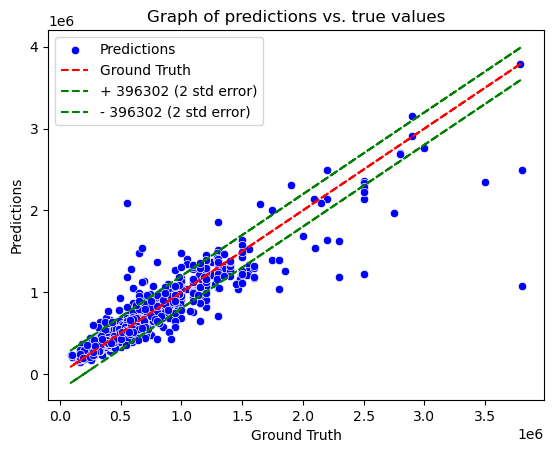

In [50]:
plot(y_test,y_pred)

#### Vamors tentar de melhorar nos prediçoes com HistGradBoost

In [ ]:

param_grid = {
'max_iter':[160,180,200],
'max_leaf_nodes':[28,20],
'l2_regularization':[35],
'max_depth':[11,12],
'loss':['least_squares','huber','absolute_error','']
}

grid_search = GridSearchCV(
estimator=HistGradientBoostingRegressor(),
param_grid=param_grid,
scoring='neg_root_mean_squared_error',
cv=5,
n_jobs=-1
)

grid_search.fit(X_train, y_train)


In [51]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
best_score = grid_search.best_score_
print("Best Cross-Validation RMSE:", -best_score)

Best Hyperparameters: {'l2_regularization': 35, 'loss': 'absolute_error', 'max_depth': 12, 'max_iter': 200, 'max_leaf_nodes': 28}
Best Cross-Validation RMSE: 198752.78084330424


In [52]:
best_reg2=HistGradientBoostingRegressor(**best_params)
y_pred=best_reg2.fit(X_train,y_train).predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE sur les données : ", rmse)

RMSE sur les données :  202492.68101053382


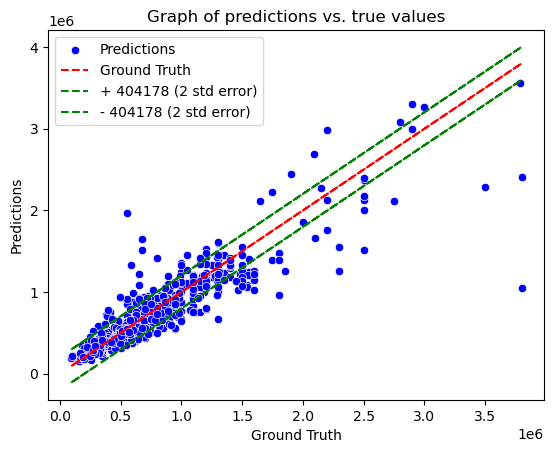

In [53]:
plot(y_test,y_pred)

In [640]:
histGB=HistGradientBoostingRegressor(**best_params).fit(X,y)

#### Fazer as previsões no conjunto de teste real

In [533]:
features.remove('preco')

In [617]:
X_test=test[features]

In [561]:
reg=RandomForestRegressor(max_depth = 11, n_estimators= 900,random_state=0).fit(X,y)

y_pred_rdf=reg.predict(X_test)

In [641]:
y_pred_hgb=histGB.predict(X_test)

In [642]:
predictions = pd.DataFrame(test.index, columns=['Id'])
predictions['preco']=y_pred_hgb
predictions=predictions.set_index('Id')
predictions

,preco
Id,
0,1.368455e+06
1,3.099836e+05
2,6.211239e+05
3,2.161561e+05
4,2.689542e+05
...,...
1995,6.823119e+05
1996,3.911595e+05
1997,4.023743e+05


In [643]:
predictions.to_csv('predictions.csv')